## Train model

In [1]:
import yaml


config = None
with open("train.yaml", 'rt') as f:
    config = yaml.safe_load(f.read())

config

{'model': {'type': 'cnn_mobilenet2', 'preprocessing': 'imagenet'},
 'dataset': {'path': 'data/train.csv',
  'val_share': 0.1,
  'train_batch': 16,
  'val_batch': 32},
 'optimizer': {'type': 'SGD', 'pars': {'lr': 0.001, 'momentum': 0.9}},
 'evaluation': {'metrics': ['accuracy_score', 'f1_score', 'confusion_matrix'],
  'period': 200},
 'autosave': {'period': 1, 'path': 'checkpoints'},
 'logs': {'path': 'logs'},
 'scheduler': {'epochs': 10}}

In [2]:
import torchvision

from dataloader import MNISTDataset
from digits_recognizer import build_model
from preprocessor import build_preprocessor
from train import *

In [3]:
model = build_model(config['model']['type'])
preprocessor = build_preprocessor(config['model']['preprocessing'])
img_transform = torchvision.transforms.Compose([
    preprocessor,
])

dataset = MNISTDataset(config['dataset']['path'], transform=img_transform)
val_target_size = int(config['dataset']['val_share'] * len(dataset))
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_target_size, val_target_size])
train_dataloader = DataLoader(train_dataset, batch_size=config['dataset']['train_batch'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['dataset']['val_batch'], shuffle=True)

optimizer = build_optimizer(model, config['optimizer'])
loss_function = torch.nn.CrossEntropyLoss()
train_metrics = {
    'accuracy': accuracy_evaluator,
}
val_metrics = {
    'accuracy': accuracy_evaluator,
    'conf_matrix': cm_evaluator,
}

#### Inspect the data

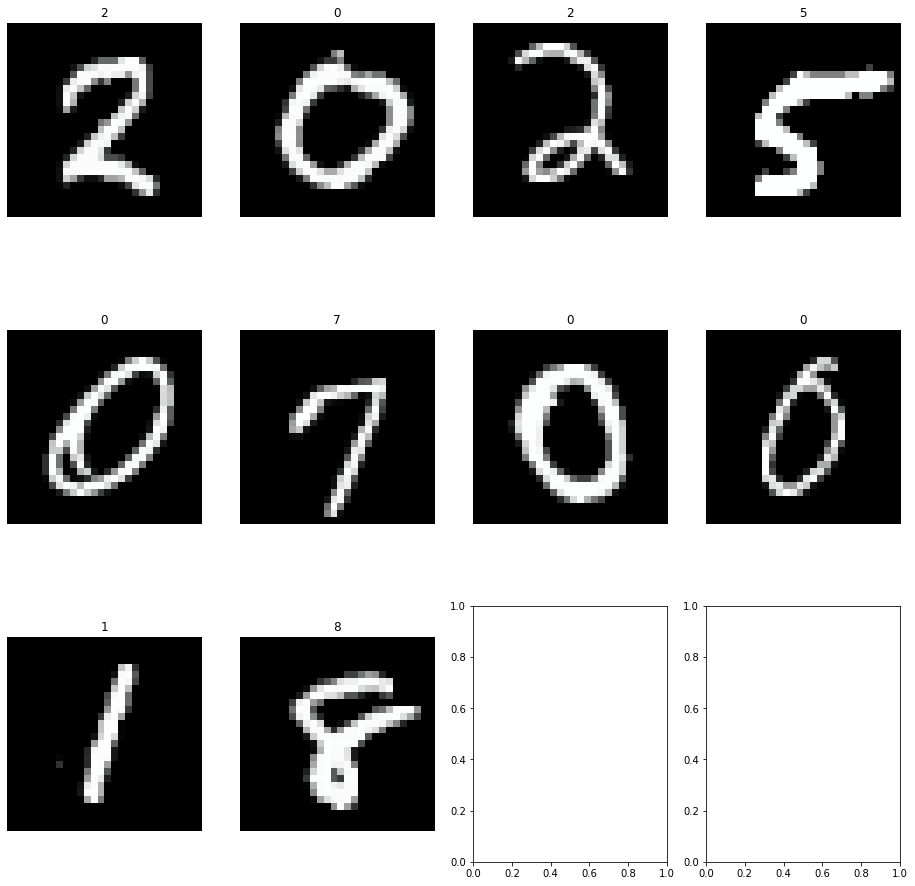

In [ ]:
from utils import plot_samples


def process_sample(sample):
    tensor, label = sample
    return preprocessor.restore(tensor), label


images = [process_sample(train_dataset[i]) for i in range(10)]
plot_samples(images)

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


Iteration 168/23630	Loss 2.191143751144409:   1%|          | 169/23630 [00:16<38:07, 10.26it/s] 


KeyboardInterrupt: 

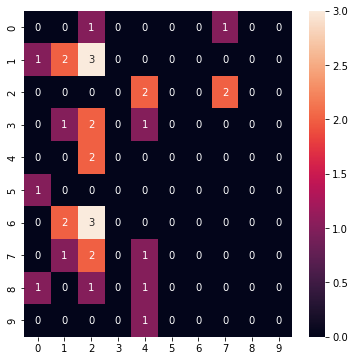

In [4]:
train(
    model,
    config['scheduler']['epochs'],
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_function,
    train_metrics,
    val_metrics,
    config['evaluation']['period'],
    config['autosave']['period'],
    logs_root="logs",
    checkpoints_root="checkpoints",
    device=None,
)

## Restore the model, evaluate it on the test subset

In [11]:
import pandas as pd

TEST_DATA_PATH = os.path.join("data", "test.csv")
df = pd.read_csv(TEST_DATA_PATH)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from digits_recognizer import InferenceModel

MODEL_CHECKPOINT = 'checkpoints/12-Jul-2022-22-05-15/'

loaded_model = build_model(config['model']['type'])
loaded_model.load_state_dict(torch.load(MODEL_CHECKPOINT))
inference_model = InferenceModel(
    model=loaded_model,
    preprocessor=build_preprocessor(config['model']['preprocessing']),
    device=get_available_device(),
)

In [10]:
from collections import defaultdict


dataset = MNISTDataset(TEST_DATA_PATH)
ans = defaultdict(list)

for sample_idx in range(len(dataset)):
    ans["ImageId"].append(sample_idx + 1)
    image, _ = dataset[sample_idx]
    prediction = inference_model.predict(image)
    ans["Label"].append(prediction)

ans_df = pd.DataFrame.from_dict(ans)
ans_df.head()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])